In [1]:
  ! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import os
from datasets import load_dataset
PATH_TO_IMAGE_FOLDER = "COCO2017"

def create_full_path(example):
    """Create full path to image using `base_path` to COCO2017 folder."""
    example["image_path"] = os.path.join(PATH_TO_IMAGE_FOLDER, example["file_name"])
    return example

dataset = load_dataset("phiyodr/coco2017")
dataset = dataset.map(create_full_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/118287 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/118287 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [3]:
dataset['train'][0]

{'license': 3,
 'file_name': 'train2017/000000391895.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'height': 360,
 'width': 640,
 'date_captured': '2013-11-14 11:18:45',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'image_id': 391895,
 'ids': [770337, 771687, 772707, 776154, 781998],
 'captions': ['A man with a red helmet on a small moped on a dirt road. ',
  'Man riding a motor bike on a dirt road on the countryside.',
  'A man riding on the back of a motorcycle.',
  'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ',
  'A man in a red shirt and a red hat is on a motorcycle on a hill side.'],
 'image_path': 'COCO2017/train2017/000000391895.jpg'}

In [4]:
!pip install datasets pillow matplotlib

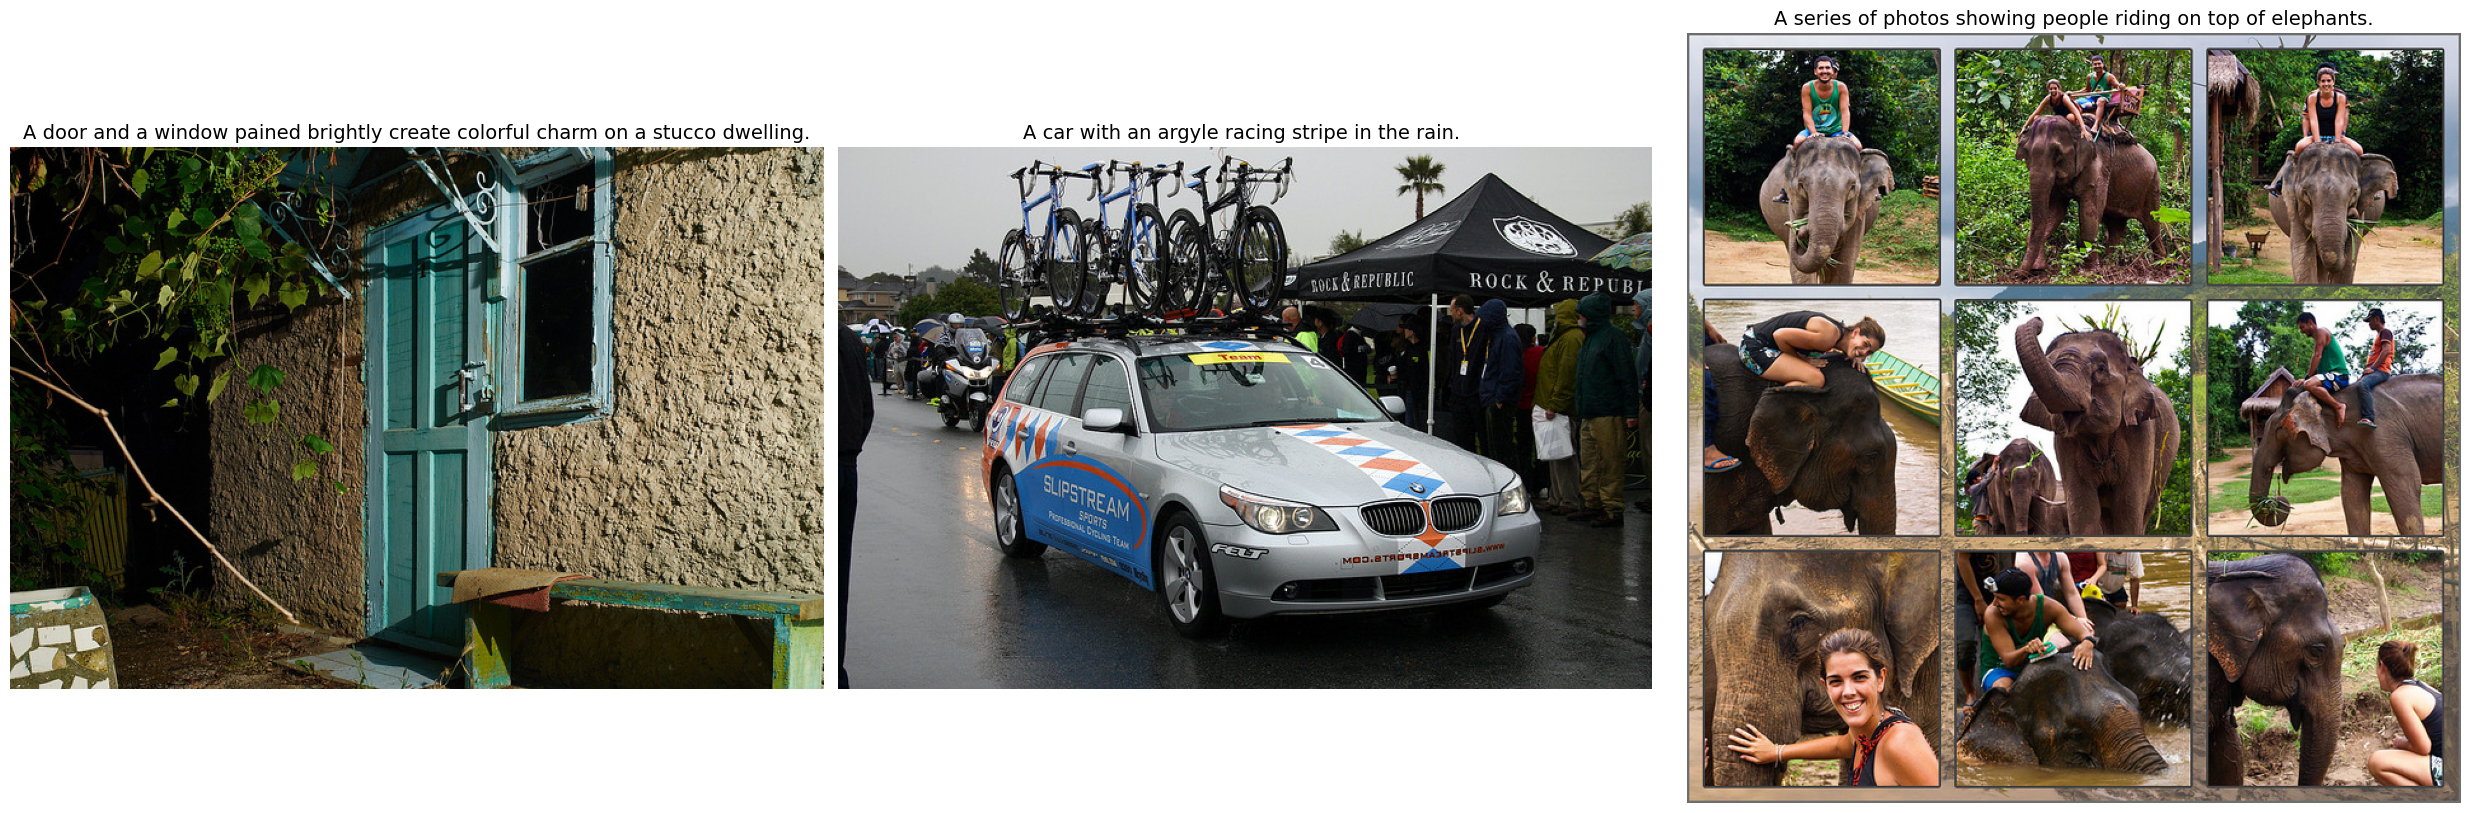

In [5]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def show_samples(dataset, n_samples=3):
    plt.figure(figsize=(25, 8))  # Set the figure size for displaying images

    for i, sample in enumerate(dataset.shuffle().select(range(n_samples))):
        # Retrieve the image from the coco_url
        image_url = sample['coco_url']
        response = requests.get(image_url)

        try:
            # Check if the request was successful
            response.raise_for_status()
            # Load the image from the web
            with Image.open(BytesIO(response.content)).convert("RGB") as image:
                # Plot the image
                plt.subplot(1, n_samples, i + 1)
                plt.imshow(image)
                plt.axis('off')

                # Plot the caption
                caption = sample['captions'][0]  # Display the first caption
                plt.title(caption, fontsize=14)
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
        except IOError as e:
            print(f"An error occurred: {e}")

    plt.tight_layout()
    plt.show()

# Display samples from the 'train' dataset
show_samples(dataset['train'], n_samples=3)

TO-DO:

- get image and captions into a format that would be readable by the `teacher_model`: look at the `SocratisDataset` and `ImageProcessor` classes in the teacher model implementation to see this.
- make predictions based on this, make sure to give evidence for choosing P and K and following the advice from the research paper.

## Get Images in Format Compatible With Teacher Model: COCODataset

In [ ]:
import os
import numpy as np
import pandas as pd

# torch
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# from visualbert
from processing_image import Preprocess
from utils import Config
from modeling_frcnn import GeneralizedRCNN

In [ ]:
class ImageProcessor:
    def __init__(self, device='cuda'):
        frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
        frcnn_cfg.MODEL.DEVICE = device
        self.device = device

        self.frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

        self.frcnn_cfg = frcnn_cfg
        self.image_preprocess = Preprocess(frcnn_cfg)

    def get_visual_embeddings(self, image_path):
        # run frcnn
        images, sizes, scales_yx = self.image_preprocess(image_path)

        output_dict = self.frcnn(
            images,
            sizes,
            scales_yx=scales_yx,
            padding="max_detections",
            max_detections=self.frcnn_cfg.max_detections,
            return_tensors="pt",
        )
        features = output_dict.get("roi_features").detach().cpu()
        return features

In [ ]:
dataset['train']

Dataset({
    features: ['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'image_id', 'ids', 'captions', 'image_path'],
    num_rows: 118287
})

In [ ]:
class COCODataset(Dataset):
    def __init__(self, dataset, device='cuda'):
        self.dataset = dataset['train']

        # feature extractors
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.visual_extractor = ImageProcessor(device=device)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        # get captions
        captions = self.dataset[idx]['captions']


        # get image embeddings
        # image is a url so we don't need a base path
        image_path = self.dataset[idx]['coco_url']
        visual_embeds = self.visual_extractor.get_visual_embeddings(image_path)
        visual_token_type_ids = torch.ones(
            visual_embeds.shape[:-1], dtype=torch.long)
        visual_attention_mask = torch.ones(
            visual_embeds.shape[:-1], dtype=torch.float)

        # get text embeddings

        # we need handle the fact that there are multiple captions (as opposed to one caption in Socratis)
        # We handle this by taking an average of the numeric values associated with the words

        input_ids_list = []
        token_type_ids_list = []
        attention_mask_list = []

        for caption in captions:
            inputs = self.tokenizer(caption, return_tensors="pt", max_length=32, truncation=True, padding='max_length')
            input_ids_list.append(inputs["input_ids"])
            token_type_ids_list.append(inputs["token_type_ids"])
            attention_mask_list.append(inputs["attention_mask"])

        input_ids = torch.cat(input_ids_list, dim=0).float().mean(dim=0).long()
        token_type_ids = torch.cat(token_type_ids_list, dim=0).float().mean(dim=0).long()
        attention_mask = torch.cat(attention_mask_list, dim=0).float().mean(dim=0).long()

        # zero at the end because we don't have labels in this case
        # note how the output of the COCODataset now matches the output of the SocratisDataset
        return (input_ids, token_type_ids, attention_mask,
                visual_embeds, visual_token_type_ids, visual_attention_mask,
                0)

## Load Teacher Model

In [ ]:
import torch.nn as nn
from transformers import VisualBertModel

In [ ]:
# Define teacher model architecture
class TeacherModel(nn.Module):
    def __init__(self, visualbert_model):
        super(TeacherModel, self).__init__()
        self.visualbert = visualbert_model
        num_emotions = 29
        self.fc = nn.Linear(self.visualbert.config.hidden_size, num_emotions)

    def forward(self, input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels):
        visualbert_outputs = self.visualbert(input_ids=input_ids.squeeze(1),
                                             attention_mask=attention_mask.squeeze(1),
                                             token_type_ids=token_type_ids.squeeze(1),
                                             visual_embeds=visual_embeds.squeeze(1),
                                            visual_token_type_ids=visual_token_type_ids.squeeze(1),
                                            visual_attention_mask=visual_attention_mask.squeeze(1))
        pooled_output = visualbert_outputs['pooler_output']

        # Emotion prediction
        logits = self.fc(pooled_output) # Loss function operates from logits

        # probabilities = F.softmax(logits, dim=-1)
        return logits

In [ ]:
visualbert_model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")# freeze --> training last layers

In [ ]:
for param in visualbert_model.parameters():
    param.requires_grad = False

In [ ]:
teacher_model = TeacherModel(visualbert_model)

In [ ]:
model_path = "trained_teacher_model.pth"
state_dict = torch.load(model_path)
teacher_model.load_state_dict(state_dict)
teacher_model.eval()

TeacherModel(
  (visualbert): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=2048, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropo

## Make Predictions on New Data

In [ ]:
coco_dataset = COCODataset(dataset)
coco_dataloader = DataLoader(coco_dataset, batch_size=1, shuffle=False)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/ota231/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


# testing this on just one item in the dataset for clarity purposes
- we see that the output for this is the probability that the image-caption pair belongs to one of the 29 emotion classes (you can refer to the `label_map` dictionary in the `Socratis_Teacher_Model.ipynb` file for more information on which index is which class)
- in this case, **P** would be the classes with the P highest scores for each image that would be retained. so are you going to keep the top 10 probabilities for each image or the top 5? A possible alternative could be thresholding: for example only keeping probabilities greater than 0.5.
- **K**: you would pick K after making all predictions. so lets say the class 0 (which by the `label_map` is the emotion curious) has 5000 images assigned to it by the time we've made all our predictions. How many of these images would we retain to the original dataset?

In [ ]:
first_item = next(iter(coco_dataloader))

/ext3/miniconda3/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
with torch.no_grad():
    input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, _ = first_item
    logits = teacher_model(input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, _)
    probabilities = torch.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities if your model's task is multilabel classification
    print(probabilities)

tensor([[0.0119, 0.0561, 0.1521, 0.0069, 0.0566, 0.0270, 0.0630, 0.0489, 0.4937,
         0.2425, 0.0291, 0.2138, 0.0389, 0.0510, 0.0135, 0.4060, 0.0203, 0.0290,
         0.0552, 0.0930, 0.2565, 0.1515, 0.0090, 0.0951, 0.4480, 0.0790, 0.8474,
         0.8687, 0.0048]])


In [ ]:
probabilities

tensor([[0.0119, 0.0561, 0.1521, 0.0069, 0.0566, 0.0270, 0.0630, 0.0489, 0.4937,
         0.2425, 0.0291, 0.2138, 0.0389, 0.0510, 0.0135, 0.4060, 0.0203, 0.0290,
         0.0552, 0.0930, 0.2565, 0.1515, 0.0090, 0.0951, 0.4480, 0.0790, 0.8474,
         0.8687, 0.0048]])

## Experiment with different values of K

In [ ]:
import ast
from tqdm import tqdm

In [ ]:
socratis_df = pd.read_csv('./cleaned_data.csv')
socratis_df.head()

image_name  \
0  conceptualcaptions__000e01606a2b934a9c893252d6...   
1  conceptualcaptions__00ccbe0b62a852f8e118ffd4f8...   
2  conceptualcaptions__01d3063cb6999c902b6bde1863...   
3  conceptualcaptions__033a2f7a224d654e384e4d1f29...   
4  conceptualcaptions__05473530007d30177a40ae7b4c...   

                                             caption  \
0  person on film character while waiting for mov...   
1  bring shimmering appeal to your sofa , bed , o...   
2  all that glitters tree ... this would be prett...   
3  musical performance role with musical instrume...   
4           dark storms gather overhead at the beach   

                                            emotions  
0                   ['curious', 'happy', 'confused']  
1                           ['curious', 'beautiful']  
2     ['excited', 'nostalgic', 'happy', 'beautiful']  
3  ['excited', 'annoyed', 'happy', 'neutral', 'in...  
4          ['concerned', 'worried', 'sad', 'scared']

In [ ]:
emotions_strings = socratis_df['emotions']

# convert strings to lists
emotions_lists = [ast.literal_eval(emotion_str) for emotion_str in emotions_strings]

# calculate average number of emotions
total_length = sum(len(emotion_list) for emotion_list in emotions_lists)
average_length = total_length / len(emotions_lists)

print(f"Average number of emotions per image in Socratis: {average_length:.4f}")

Average number of emotions per image in Socratis: 3.9811


In [ ]:
def apply_threshold(probabilities, threshold):
    binary_predictions = (probabilities > threshold).float()
    return binary_predictions

def select_top_k(probabilities, top_k):
    top_k_probabilities, top_k_indices = torch.topk(probabilities, k=top_k, dim=1)

    top_k_predictions = torch.zeros_like(probabilities)
    top_k_predictions.scatter_(1, top_k_indices, 1)

    return top_k_predictions

In [ ]:
def process_predictions(coco_dataloader, teacher_model, threshold=None, top_k=None, checkpoint_path=None):
    predictions_list = []
    checkpoint_file = 'coco_predictions_checkpoint.pt'

    if checkpoint_path:
        checkpoint_file = os.path.join(checkpoint_path, checkpoint_file)
        if os.path.exists(checkpoint_file):
            predictions_list = torch.load(checkpoint_file)
            start_idx = len(predictions_list)
        else:
            start_idx = 0
    else:
        start_idx = 0

    # Initialize tqdm with initial value
    pbar = tqdm(total=len(coco_dataloader), desc="Processing", initial=start_idx)

    with torch.no_grad():
        for idx, batch in enumerate(coco_dataloader, start=start_idx):
            input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, _ = batch
            logits = teacher_model(input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, _)
            probabilities = torch.sigmoid(logits)

            if threshold is not None:
                predictions = apply_threshold(probabilities, threshold)
            elif top_k is not None:
                predictions = select_top_k(probabilities, top_k)

            predictions_list.append(predictions)
            pbar.update(1)

            # Save checkpoint
            if checkpoint_path:  # save everytime
                torch.save(predictions_list, checkpoint_file)

    pbar.close()  # Close tqdm progress bar

    return torch.cat(predictions_list, dim=0)

In [ ]:
coco_dataset = COCODataset(dataset)
coco_dataloader = DataLoader(coco_dataset, batch_size=64, shuffle=False)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/ota231/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [ ]:
threshold = 0.5
top_k = 4

Both options take at least 12 hours to run, so we voted as a group to take the `top_k` options since there is increased rationale behind it :)

In [ ]:
checkpoint_path = './'

In [ ]:
predictions_top_k = process_predictions(coco_dataloader, teacher_model, top_k=top_k, checkpoint_path=checkpoint_path)

Processing: 1860it [3:08:17, 24.80s/it]                                     

KeyboardInterrupt: 

In [ ]:
print('Done')

Done
